LOOK UP CODE IN WRANGLE WHERE 0'S ARE DELETED
---

imports
---

In [0]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [0]:
pip install -U scikit-learn scipy matplotlib

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import psutil
import os
import numpy as np
from sklearn.feature_selection import f_regression, SelectKBest
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import randint, uniform
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
import pandas as pd
# import plotly_express as px
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier

Using TensorFlow backend.


I WAS using a RAM intensive data, the following code let me see how much RAM I am using. Had to run this to see how close I was to crashing after new implimintations. 
---

In [0]:
# used to see how much RAM is being used
py = psutil.Process(os.getpid())
print('RAM usage: {} GB'.format(py.memory_info()[0]/2. ** 30))

RAM usage: 0.39781951904296875 GB


Function that helps optimize the data stored in my dataframes.
---

In [0]:
def reduce_mem_usage(df):
    """ 
        iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

Code used to read in csv files from Google Drive into colab.
---

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
data = 'https://drive.google.com/open?id=1-76gbkPzL5IedwIMo30EEHGIW7m0poKa'
fluff, id = data.split('=')
print (id) # Verify that you have everything after '=''
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('nba_logreg.csv') 

1-76gbkPzL5IedwIMo30EEHGIW7m0poKa


Code that calls the function and to show how much RAM each data frame uses before/after being passed through the optimization function.
---

In [5]:
print('-' * 80)
print('data')
nba = import_data('nba_logreg.csv')

--------------------------------------------------------------------------------
data
Memory usage of dataframe is 0.21 MB
Memory usage after optimization is: 0.10 MB
Decreased by 52.8%


Printing the heads of the dataframes to see what each contains
---

In [6]:
print(nba.shape)
nba.head()

(1340, 21)


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.406250,7.398438,2.599609,7.601562,34.68750,0.500000,2.099609,25.00000,1.599609,2.300781,69.875,0.700195,3.400391,4.101562,1.900391,0.399902,0.399902,1.299805,0.0
1,Andrew Harrison,35,26.906250,7.199219,2.000000,6.699219,29.59375,0.700195,2.800781,23.50000,2.599609,3.400391,76.500,0.500000,2.000000,2.400391,3.699219,1.099609,0.500000,1.599609,0.0
2,JaKarr Sampson,74,15.296875,5.199219,2.000000,4.699219,42.18750,0.399902,1.700195,24.40625,0.899902,1.299805,67.000,0.500000,1.700195,2.199219,1.000000,0.500000,0.300049,1.000000,0.0
3,Malik Sealy,58,11.601562,5.699219,2.300781,5.500000,42.59375,0.099976,0.500000,22.59375,0.899902,1.299805,68.875,1.000000,0.899902,1.900391,0.799805,0.600098,0.099976,1.000000,1.0
4,Matt Geiger,48,11.500000,4.500000,1.599609,3.000000,52.40625,0.000000,0.099976,0.00000,1.299805,1.900391,67.375,1.000000,1.500000,2.500000,0.300049,0.300049,0.399902,0.799805,1.0


In [7]:
nba.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.625000,6.800781,2.628906,5.886719,44.187500,0.247559,0.779297,19.312500,1.297852,1.822266,inf,1.009766,2.025391,3.035156,1.550781,0.618652,0.368408,1.193359,0.620117
std,17.433992,8.304688,4.355469,1.683594,3.591797,6.136719,0.383789,1.062500,16.015625,0.987305,1.323242,10.578125,0.777344,1.360352,2.058594,1.470703,0.409668,0.428955,0.722656,0.485352
min,11.000000,3.099609,0.700195,0.300049,0.799805,23.796875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199951,0.300049,0.000000,0.000000,0.000000,0.099976,0.000000
25%,47.000000,10.873047,3.699219,1.400391,3.300781,40.187500,0.000000,0.000000,0.000000,0.600098,0.899902,64.687500,0.399902,1.000000,1.500000,0.600098,0.300049,0.099976,0.700195,0.000000
50%,63.000000,16.093750,5.550781,2.099609,4.800781,44.093750,0.099976,0.300049,22.406250,1.000000,1.500000,71.250000,0.799805,1.700195,2.500000,1.099609,0.500000,0.199951,1.000000,1.000000
75%,77.000000,22.906250,8.796875,3.400391,7.500000,47.906250,0.399902,1.200195,32.500000,1.599609,2.300781,77.625000,1.400391,2.599609,4.000000,2.000000,0.799805,0.500000,1.500000,1.000000
max,82.000000,40.906250,28.203125,10.203125,19.796875,73.687500,2.300781,6.500000,100.000000,7.699219,10.203125,100.000000,5.300781,9.601562,13.898438,10.601562,2.500000,3.900391,4.398438,1.000000


Baseline score
---

In [8]:
print('Baseline Score',nba['TARGET_5Yrs'].mean(),'%')

Baseline Score 0.62 %


Pairplot to show the correlation between varaibles
---

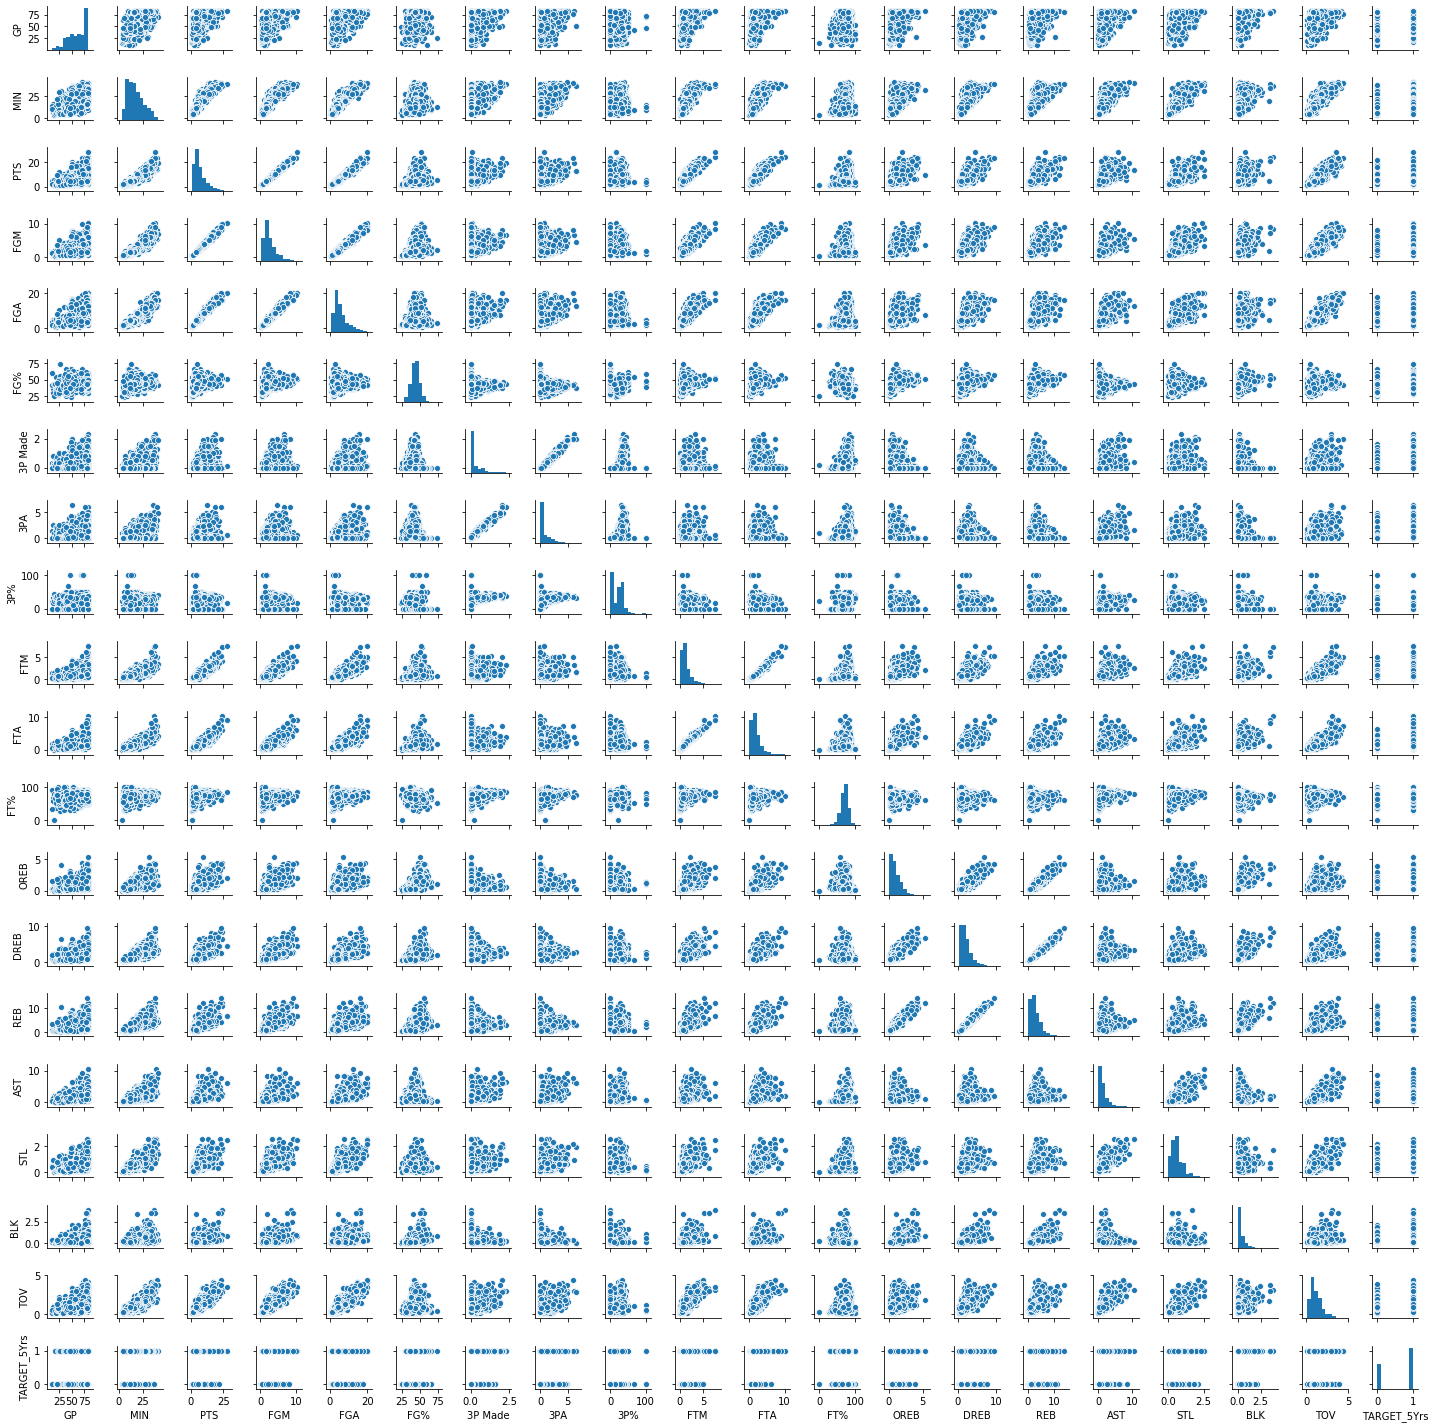

In [10]:
sns.pairplot(nba, size=1);

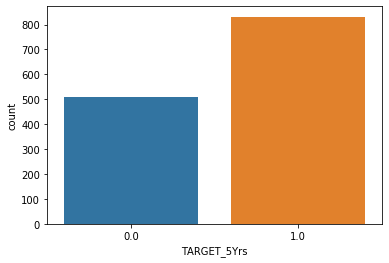

In [11]:
# total count of players who did and did not make it the five years.
sns.countplot("TARGET_5Yrs", data = nba)

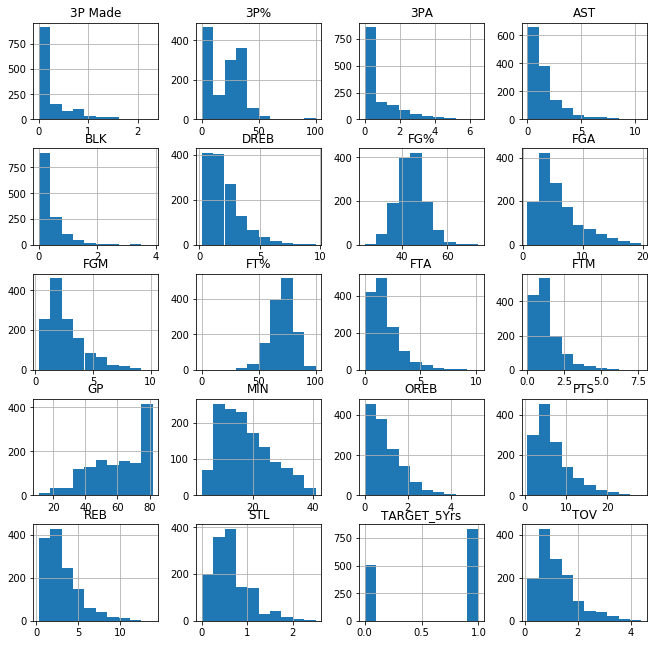

In [12]:
# distribution of each variable
fig = plt.figure(figsize = (11,11))
ax = fig.gca()
nba.hist(ax=ax)
plt.show()

Start of the train/val/test split
---

In [0]:
# Spliting into features and target vector
X = nba.drop(columns='TARGET_5Yrs')
y = nba['TARGET_5Yrs']

In [0]:
# train_validation_test_split function
def train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, random_state=1)

In [16]:
# Shapre of outputs
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1005, 20), (134, 20), (201, 20), (1005,), (134,), (201,))

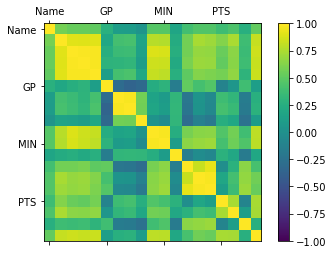

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
GP,1.000000,0.578440,0.531760,0.536933,0.511611,0.268810,0.111897,0.105078,0.036684,0.472616,0.470339,0.173523,0.394520,0.457969,0.453482,0.377749,0.442771,0.263124,0.520344
MIN,0.578440,1.000000,0.911572,0.903088,0.909627,0.195211,0.405505,0.419792,0.163014,0.783549,0.770189,0.233736,0.572072,0.739062,0.707670,0.627736,0.746572,0.377210,0.823858
PTS,0.531760,0.911572,1.000000,0.990704,0.978912,0.251499,0.360548,0.370711,0.144518,0.892824,0.877298,0.250710,0.577511,0.686851,0.675440,0.542432,0.655878,0.365885,0.849027
FGM,0.536933,0.903088,0.990704,1.000000,0.978593,0.290747,0.302991,0.312572,0.110692,0.844340,0.837680,0.214172,0.599759,0.696871,0.690550,0.523265,0.642382,0.378822,0.833610
FGA,0.511611,0.909627,0.978912,0.978593,1.000000,0.121374,0.406475,0.429855,0.187536,0.822353,0.800314,0.262981,0.501250,0.629304,0.608456,0.579919,0.670950,0.298745,0.842459
FG%,0.268810,0.195211,0.251499,0.290747,0.121374,1.000000,-0.296313,-0.353296,-0.315635,0.239299,0.294046,-0.156182,0.518514,0.408223,0.467312,-0.104790,0.049762,0.389286,0.121276
3P Made,0.111897,0.405505,0.360548,0.302991,0.406475,-0.296313,1.000000,0.982638,0.575295,0.160373,0.095188,0.316252,-0.209064,0.031996,-0.057053,0.382501,0.316087,-0.160504,0.263060
3PA,0.105078,0.419792,0.370711,0.312572,0.429855,-0.353296,0.982638,1.000000,0.566013,0.177979,0.109670,0.327339,-0.221207,0.028540,-0.064078,0.412275,0.346037,-0.175325,0.286274
3P%,0.036684,0.163014,0.144518,0.110692,0.187536,-0.315635,0.575295,0.566013,1.000000,0.030332,-0.031346,0.315541,-0.287653,-0.121559,-0.189323,0.254008,0.192511,-0.249625,0.103743
FTM,0.472616,0.783549,0.892824,0.844340,0.822353,0.239299,0.160373,0.177979,0.030332,1.000000,0.979363,0.249980,0.587551,0.642729,0.649450,0.457660,0.577794,0.386616,0.801052


In [17]:
# heat map and table of correlations
correlations = X_train.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
names = ['']+list(X_train)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()
correlations

Feature Importance
---

In [0]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

Accuracy of the GBM on test set: 0.706
              precision    recall  f1-score   support

         0.0       0.60      0.64      0.62        76
         1.0       0.78      0.74      0.76       125

    accuracy                           0.71       201
   macro avg       0.69      0.69      0.69       201
weighted avg       0.71      0.71      0.71       201



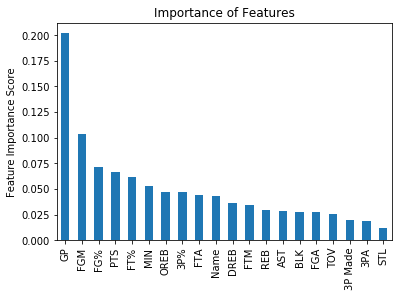

In [19]:
from sklearn.metrics import classification_report

baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train_processed,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(X_test_processed, y_test)))
pred=baseline.predict(X_test_processed)
print(classification_report(y_test, pred))

ROC AUC score
---

In [20]:
processor = make_pipeline(ce.OrdinalEncoder(), SimpleImputer(strategy='mean'))
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBClassifier(n_estimators=100, n_jobs=-1)

model.fit(X_train_transformed, y_train, eval_set=eval_set, 
          eval_metric='error', early_stopping_rounds=20)

[0]	validation_0-error:0.267662	validation_1-error:0.313433
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.273632	validation_1-error:0.320896
[2]	validation_0-error:0.272637	validation_1-error:0.313433
[3]	validation_0-error:0.262687	validation_1-error:0.298507
[4]	validation_0-error:0.258706	validation_1-error:0.291045
[5]	validation_0-error:0.253731	validation_1-error:0.291045
[6]	validation_0-error:0.262687	validation_1-error:0.30597
[7]	validation_0-error:0.257711	validation_1-error:0.30597
[8]	validation_0-error:0.249751	validation_1-error:0.298507
[9]	validation_0-error:0.253731	validation_1-error:0.298507
[10]	validation_0-error:0.258706	validation_1-error:0.298507
[11]	validation_0-error:0.247761	validation_1-error:0.298507
[12]	validation_0-error:0.252736	validation_1-error:0.291045
[13]	validation_0-error:0.248756	validation_1-error:0.2910

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7197368421052631


**The ROC AUC score of 0.71 suggests that this model does a mediocre job at prediciting a players odds of making it five years.**

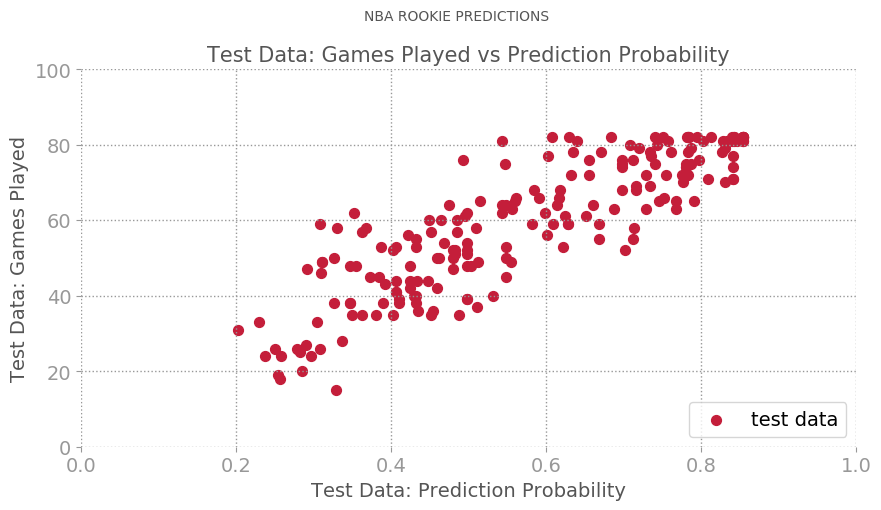

In [22]:
# Scatter plot of Games played (GP) vs Prediction Probablitly 

# Declare colors
silver = '#989898'
drk_gray = '#555555'
cardinals_red = '#C41E3A'
blues_drk = '#0f1f48'
blues_lt = '#0447a0'
blues_gold = '#ffc325'

# Create a new figure
plt.figure(figsize=(10, 5), dpi=100)


# plt.xticks(nba['name'], rotation='vertical')

plt.tick_params(
    axis='both', 
    which='major', 
    labelsize=14, 
    colors=silver)

axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_visible(False)

plt.scatter(
    y_pred_proba, 
    X_test['GP'], 
    c = cardinals_red, s=50, label = 'test data')

plt.xlabel('Test Data: Prediction Probability',
           fontsize=14,
           color=drk_gray)
plt.ylabel('Test Data: Games Played',
           fontsize=14,
           color=drk_gray)


plt.title('Test Data: Games Played vs Prediction Probability',
    fontsize=15,
    color=drk_gray)
plt.suptitle(
    'NBA ROOKIE PREDICTIONS', 
    y = 1, 
    color = drk_gray,
    fontsize = 10)

axes.grid(
    axis='both', 
    color=silver, 
    linestyle='dotted', 
    linewidth=1,
    zorder=1)
leg = axes.legend(loc='lower right', prop={'size': 14})
ax = plt.gca()
ax.axis([0,1,0,100])

fig = plt.gcf()

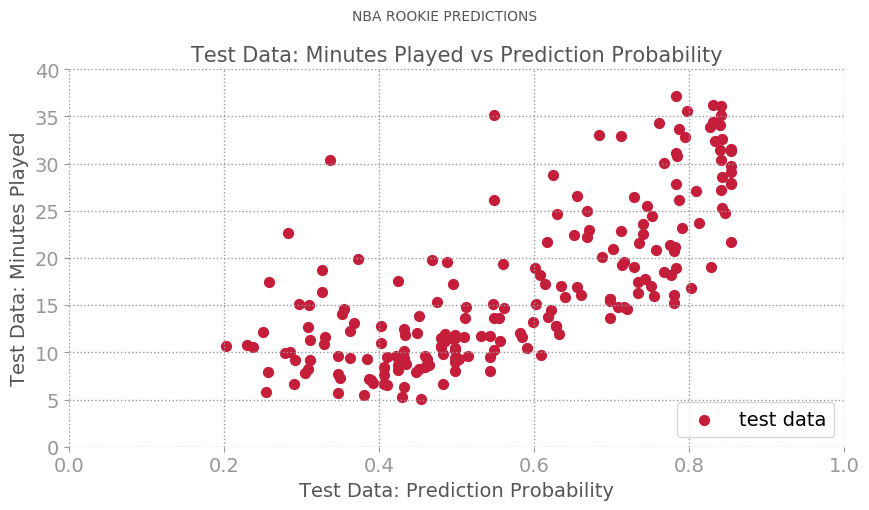

In [23]:
# Scatter plot of Minutes played (MIN) vs Prediction Probablitly 

# Declare colors
silver = '#989898'
drk_gray = '#555555'
cardinals_red = '#C41E3A'
blues_drk = '#0f1f48'
blues_lt = '#0447a0'
blues_gold = '#ffc325'

# Create a new figure
plt.figure(figsize=(10, 5), dpi=100)


# plt.xticks(nba['name'], rotation='vertical')

plt.tick_params(
    axis='both', 
    which='major', 
    labelsize=14, 
    colors=silver)

axes = plt.gca()
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['left'].set_visible(False)
axes.spines['bottom'].set_visible(False)

plt.scatter(
    y_pred_proba, 
    X_test['MIN'], 
    c = cardinals_red, s=50, label = 'test data')

plt.xlabel('Test Data: Prediction Probability',
           fontsize=14,
           color=drk_gray)
plt.ylabel('Test Data: Minutes Played',
           fontsize=14,
           color=drk_gray)


plt.title('Test Data: Minutes Played vs Prediction Probability',
    fontsize=15,
    color=drk_gray)
plt.suptitle(
    'NBA ROOKIE PREDICTIONS', 
    y = 1, 
    color = drk_gray,
    fontsize = 10)

axes.grid(
    axis='both', 
    color=silver, 
    linestyle='dotted', 
    linewidth=1,
    zorder=1)
leg = axes.legend(loc='lower right', prop={'size': 14})
ax = plt.gca()
ax.axis([0,1,0,40])

fig = plt.gcf()

Train/Validation Accuracy scores.
---

In [24]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42,
                           n_estimators=350,
                           max_depth=100,
                           min_samples_leaf=.1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.708457711442786
Validation Accuracy 0.7164179104477612


visuals
---

**Shap plots of individual random players to show how features contributed to their longevity in their careers.**


In [25]:
import shap
random_number = 43
row = X_val.iloc[[random_number]]
row_transformed = processor.transform(row)
print(row)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_transformed)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

             Name  GP        MIN       PTS  ...       AST  STL       BLK       TOV
783  Corey Brewer  79  22.796875  5.800781  ...  1.400391  1.0  0.300049  1.099609

[1 rows x 20 columns]


In [26]:
random_number = 16
row = X_val.iloc[[random_number]]
row_transformed = processor.transform(row)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_transformed)
print(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

              Name  GP       MIN       PTS  ...       AST       STL       BLK  TOV
367  Charles Jones  29  16.40625  3.699219  ...  1.400391  0.600098  0.199951  1.0

[1 rows x 20 columns]


In [27]:
random_number = 1
row = X_val.iloc[[random_number]]
row_transformed = processor.transform(row)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_transformed)
print(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

              Name  GP        MIN  ...       STL       BLK       TOV
357  Jay Humphries  80  25.796875  ...  1.299805  0.099976  2.099609

[1 rows x 20 columns]


In [28]:
random_number = 7
row = X_val.iloc[[random_number]]
row_transformed = processor.transform(row)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row_transformed)
print(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

                Name  GP        MIN  ...       STL       BLK       TOV
858  Marvin Williams  79  24.703125  ...  0.600098  0.300049  1.099609

[1 rows x 20 columns]


More Visuals contributing to feature importance.
---

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


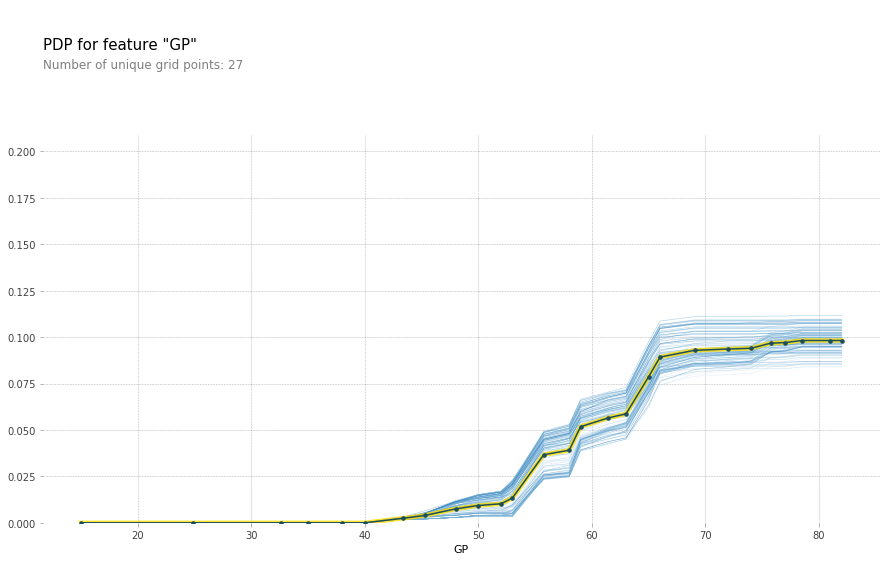

In [29]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'GP'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    num_grid_points=30
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

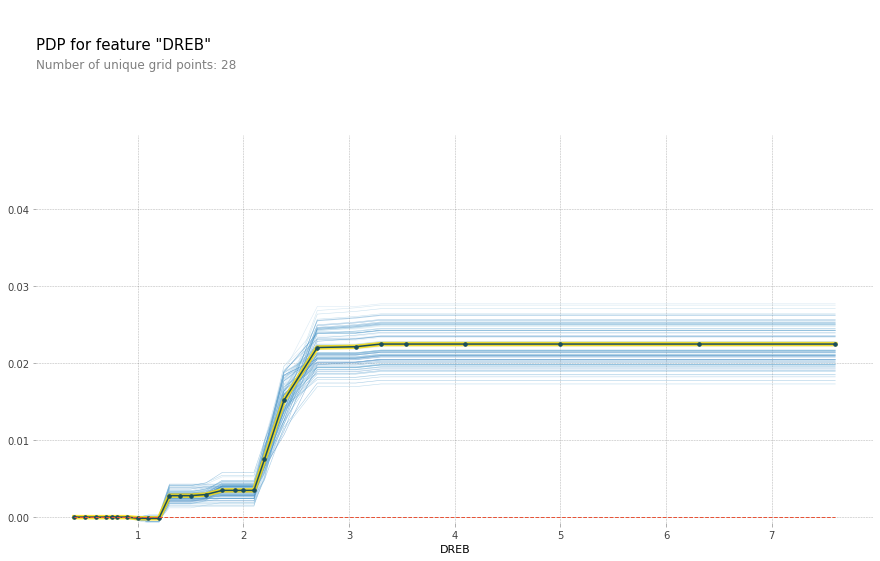

In [30]:
feature = 'DREB'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    num_grid_points=30
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

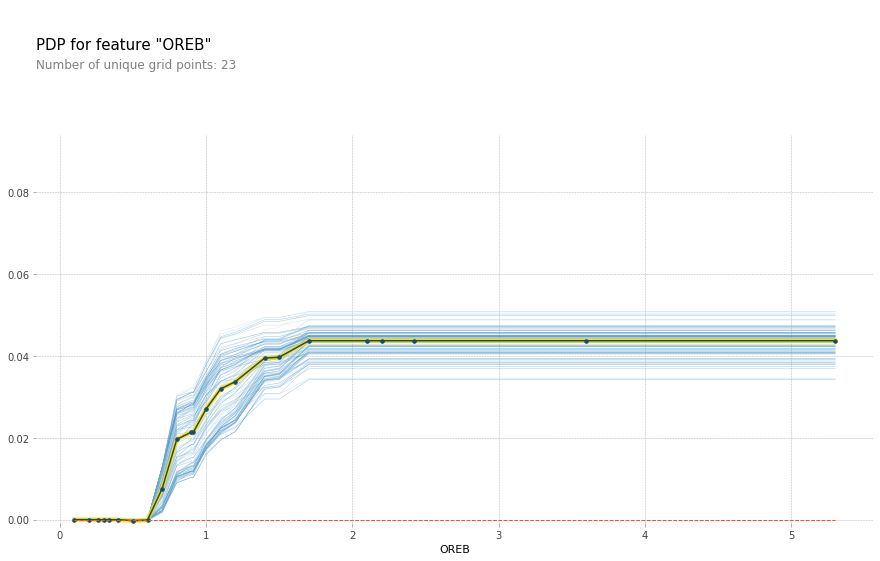

In [31]:
feature = 'OREB'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    num_grid_points=30
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

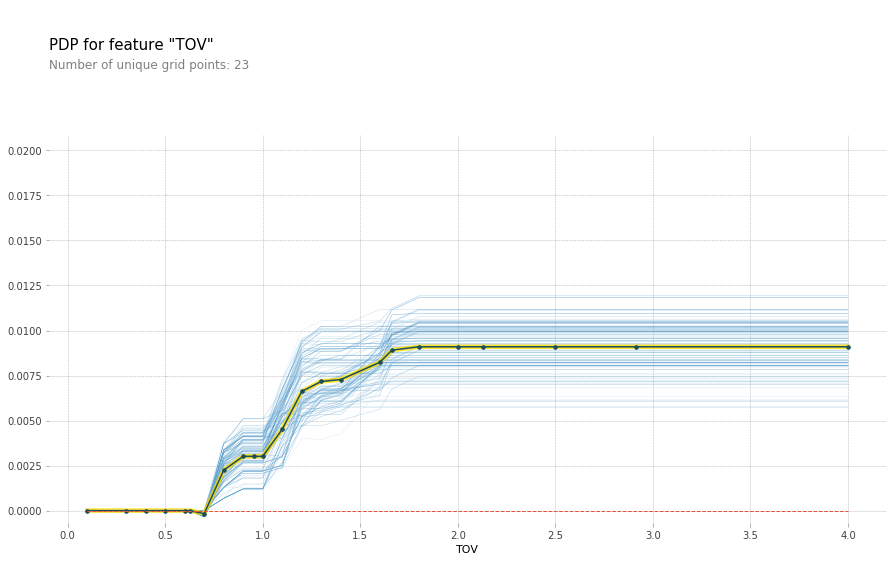

In [32]:
feature = 'TOV'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    num_grid_points=30
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

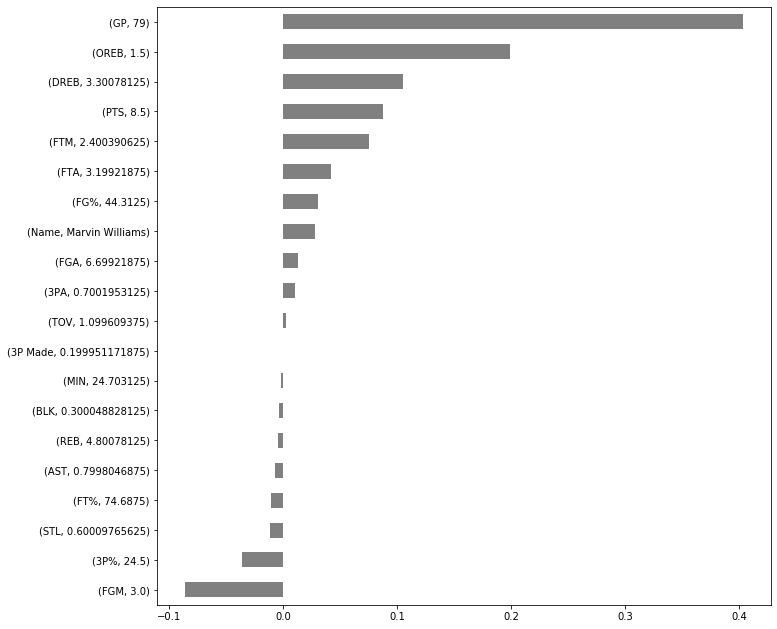

In [33]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(11,11));

In [34]:
permuter = PermutationImportance(model, scoring='neg_mean_absolute_error', n_iter=3)
permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.0995 ± 0.0601,GP
0.0299 ± 0.0122,OREB
0.0273 ± 0.0187,PTS
0.0223 ± 0.0440,FTM
0.0149 ± 0.0000,DREB
0.0076 ± 0.0000,Name
0.0076 ± 0.0000,REB
0.0075 ± 0.0122,3P%
0.0075 ± 0.0322,FT%
0.0050 ± 0.0140,FGA


Dropping features that show very little to no importance
---

In [0]:
nba_copy = nba

In [0]:
nba_copy = nba.drop(columns=['DREB','TOV','MIN','AST','FTA','3P Made','3PA','BLK','FGM','STL','FG%','REB','FGA'])

New accuracy score
---

In [0]:
X = nba_copy.drop(columns='TARGET_5Yrs')
y = nba_copy['TARGET_5Yrs']

In [0]:
def train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.75, val_size=0.1, test_size=0.15, random_state=1)

In [52]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1005, 7), (134, 7), (201, 7), (1005,), (134,), (201,))

In [53]:
processor = make_pipeline(ce.OrdinalEncoder(),
                          SimpleImputer(strategy='mean'))
X_train_transformed = processor.fit_transform(X_train)
X_val_transformed = processor.transform(X_val)

eval_set = [(X_train_transformed, y_train), 
            (X_val_transformed, y_val)]

model = XGBClassifier(n_estimators=100, 
                      n_jobs=-1)

model.fit(X_train_transformed, 
          y_train, 
          eval_set=eval_set, 
          eval_metric='error', 
          early_stopping_rounds=20)

[0]	validation_0-error:0.285572	validation_1-error:0.30597
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 20 rounds.
[1]	validation_0-error:0.285572	validation_1-error:0.291045
[2]	validation_0-error:0.277612	validation_1-error:0.283582
[3]	validation_0-error:0.281592	validation_1-error:0.291045
[4]	validation_0-error:0.272637	validation_1-error:0.291045
[5]	validation_0-error:0.278607	validation_1-error:0.283582
[6]	validation_0-error:0.277612	validation_1-error:0.291045
[7]	validation_0-error:0.271642	validation_1-error:0.291045
[8]	validation_0-error:0.268657	validation_1-error:0.291045
[9]	validation_0-error:0.256716	validation_1-error:0.283582
[10]	validation_0-error:0.259701	validation_1-error:0.283582
[11]	validation_0-error:0.261692	validation_1-error:0.283582
[12]	validation_0-error:0.258706	validation_1-error:0.283582
[13]	validation_0-error:0.252736	validation_1-error:0.283

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [54]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

Test ROC AUC for class 1:
0.7138947368421054


In [55]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42,
                           n_estimators=350,
                           max_depth=100,
                           min_samples_leaf=.1))

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train, val
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Train Accuracy 0.7154228855721393
Validation Accuracy 0.7238805970149254
